<h1 align="center"> INF6804 Lab 2: BRIEF descriptor </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [ ]:
import numpy as np
from skimage import data, io
from skimage.feature import BRIEF, corner_peaks, corner_fast, match_descriptors, plot_matches
import matplotlib.pyplot as plt
from sgm import *
import glob

### BRIEF descriptor on KITTI dataset

In [ ]:
# source: https://github.com/gabilodeau/INF6804/blob/master/Descripteur%20BRIEF.ipynb

img1 = io.imread('KITTI/data_scene_flow/training/image_2/000000_10.png', as_gray= True)
img2 = io.imread('KITTI/data_scene_flow/training/image_2/000000_11.png', as_gray= True)
plt.imshow(img2, cmap='gray')
plt.show()

# extracting key points

kps1 = corner_peaks(corner_fast(img1), min_distance=5)
kps2 = corner_peaks(corner_fast(img2), min_distance=5)

# BRIEF descriptor

extractor = BRIEF(descriptor_size=128, patch_size=5, mode='normal')

extractor.extract(img1, kps1)
descriptor1 = extractor.descriptors
extractor.extract(img2, kps2)
descriptor2 = extractor.descriptors

# matching

matches = match_descriptors(descriptor1, descriptor2, cross_check=True)

# visualization

fig = plt.figure(figsize=(36, 20)) 
ax0 = plt.subplot()
plot_matches(ax0, img1, img2, kps1, kps2, matches)
ax0.axis('off')
ax0.set_title("Image1 vs. Image2")
plt.show()

In [ ]:
plt.imshow(descriptor1, cmap='gray')
plt.show()

### SGM disparity estimation

In [144]:
# Source: https://github.com/beaupreda/semi-global-matching (with modification)

def compute_costs(left, right, parameters, save_images):
    """
    first step of the sgm algorithm
    :param left: left descriptor.
    :param right: right descriptor.
    :param parameters: structure containing parameters of the algorithm.
    :param save_images: whether to save census images or not.
    :return: H x W x D array with the matching costs.
    """
    
    max_disparity=64
    P1=5
    P2=70
    csize=(7, 7)
    bsize=(3, 3)
    
    assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
    assert parameters.max_disparity > 0, 'maximum disparity must be greater than 0.'

    height = left.shape[0]
    width = left.shape[1]
    cheight = parameters.csize[0]
    cwidth = parameters.csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)
    disparity = parameters.max_disparity

    left_census_values = left
    right_census_values = right

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int64)
    rcensus = np.zeros(shape=(height, width), dtype=np.int64)
    for d in range(0, disparity):
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        left_xor = np.int64(np.bitwise_xor(np.int64(left_census_values), rcensus))
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        left_cost_volume[:, :, d] = left_distance

        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        right_xor = np.int64(np.bitwise_xor(np.int64(right_census_values), lcensus))
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume

In [168]:
def get_recall(disparity, gt, disp):
    """
    computes the recall of the disparity map.
    :param disparity: disparity image.
    :param gt: path to ground-truth image.
    :param args: program arguments.
    :return: rate of correct predictions.
    """
    gt = np.float32(cv2.imread(gt, cv2.IMREAD_GRAYSCALE))
    gt = gt[1:gt.shape[0]-1, 1:gt.shape[1]-1]
    gt = np.int16(gt / 255.0 * float(disp))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(disp))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [184]:
def sgm(descriptorL, descriptorR, basename, gt1, gt2):
    """
    main function applying the semi-global matching algorithm.
    :return: void.
    """

    disparity = 64
    save_images = False
    evaluation = True
    output_name = basename
    left_gt_name = gt1
    right_gt_name = gt2

    #dawn = t.time()

    parameters = Parameters(max_disparity=disparity, P1=10, P2=120, csize=(7, 7), bsize=(3, 3))
    paths = Paths()

    print('\nStarting cost computation...')
    left_cost_volume, right_cost_volume = compute_costs(descriptorL, descriptorR, parameters, save_images)

    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, parameters, paths)
    print('\nStarting right aggregation computation...')
    right_aggregation_volume = aggregate_costs(right_cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), parameters))
    right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), parameters))
    if save_images:
        cv2.imwrite('left_disp_map_no_post_processing.png', left_disparity_map)
        cv2.imwrite('right_disp_map_no_post_processing.png', right_disparity_map)

    print('\nApplying median filter...')
    left_disparity_map = cv2.medianBlur(left_disparity_map, parameters.bsize[0])
    right_disparity_map = cv2.medianBlur(right_disparity_map, parameters.bsize[0])
    cv2.imwrite(f'left_disp_{output_name}', left_disparity_map)
    cv2.imwrite(f'right_disp_{output_name}', right_disparity_map)

    if evaluation:
        print('\nEvaluating left disparity map...')
        left_recall = get_recall(left_disparity_map, left_gt_name, disparity)
        print('\tRecall left= {:.2f}%'.format(left_recall * 100.0))
        print('\nEvaluating right disparity map...')
        right_recall = get_recall(right_disparity_map, right_gt_name, disparity)
        print('\tRecall right= {:.2f}%'.format(right_recall * 100.0))

    #dusk = t.time()
    #print('\nFin.')
    #print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    
    return left_disparity_map, right_disparity_map, left_recall, right_recall

255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.10s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 29.17s)
	Processing paths south-east and north-west...	(done in 29.61s)
	Processing paths south and north...	(done in 29.71s)
	Processing paths south-west and north-east...	(done in 39.63s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 31.34s)
	Processing paths south-east and north-west...	(done in 30.06s)
	Processing paths south and north...	(done in 29.12s)
	Processing paths south-west and north-east...	(done in 29.71s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 83.90%

Evaluating right disparity map...
	Recall right= 87.18%


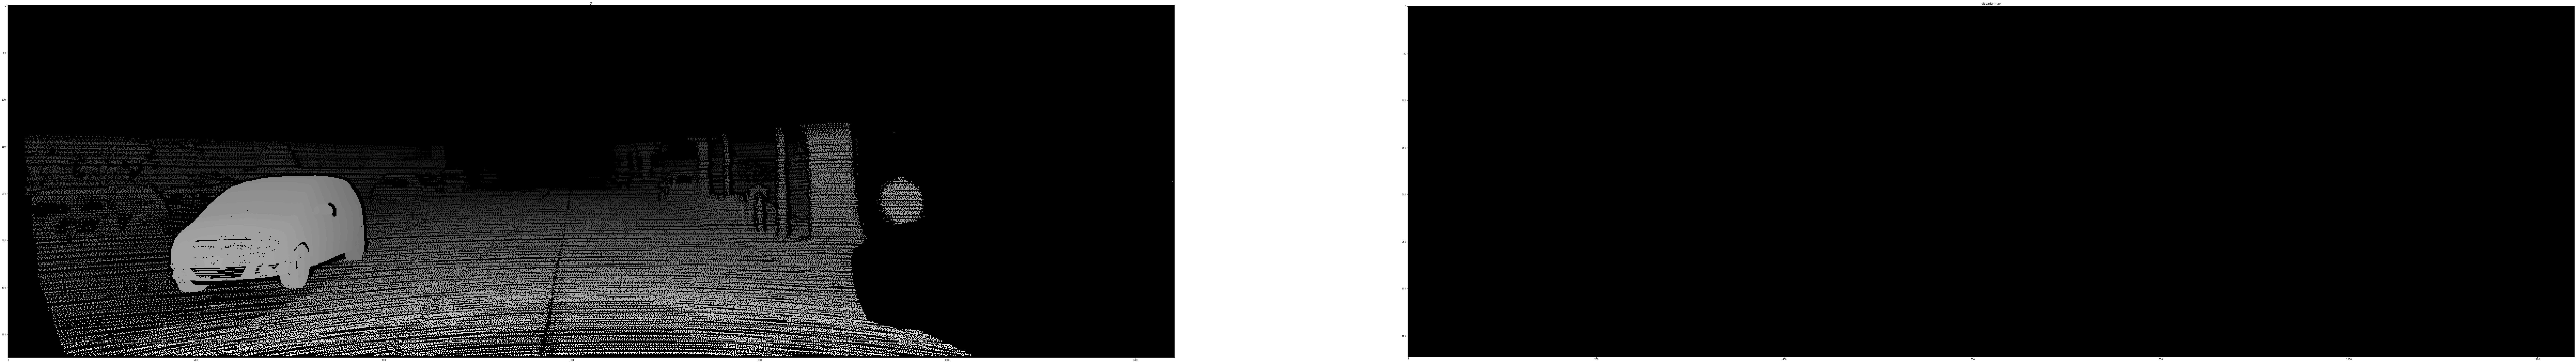


Image KITTI/data_scene_flow/training/image_2\000000_10.png processing finished.

Total execution time = 268.64s
255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.11s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 29.10s)
	Processing paths south-east and north-west...	(done in 29.51s)
	Processing paths south and north...	(done in 30.12s)
	Processing paths south-west and north-east...	(done in 35.44s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 29.13s)
	Processing paths south-east and north-west...	(done in 29.36s)
	Processing paths south and north...	(done in 28.87s)
	Processing paths south-west and north-east...	(done in 29.55s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 80.23%

Evaluating right disparity map...
	Recall right= 85.39%


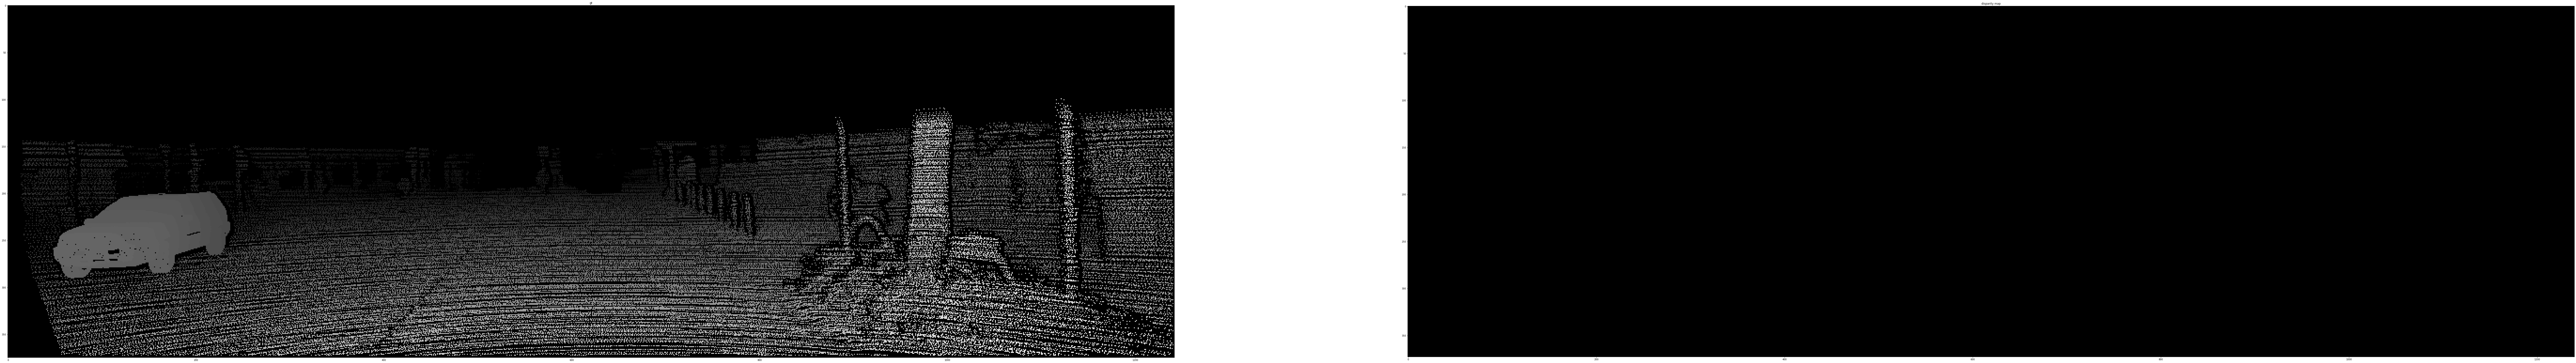


Image KITTI/data_scene_flow/training/image_2\000001_10.png processing finished.

Total execution time = 261.51s
255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.11s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 28.34s)
	Processing paths south-east and north-west...	(done in 29.09s)
	Processing paths south and north...	(done in 29.16s)
	Processing paths south-west and north-east...	(done in 30.22s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 29.42s)
	Processing paths south-east and north-west...	(done in 30.45s)
	Processing paths south and north...	(done in 30.28s)
	Processing paths south-west and north-east...	(done in 30.20s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 80.44%

Evaluating right disparity map...
	Recall right= 81.31%


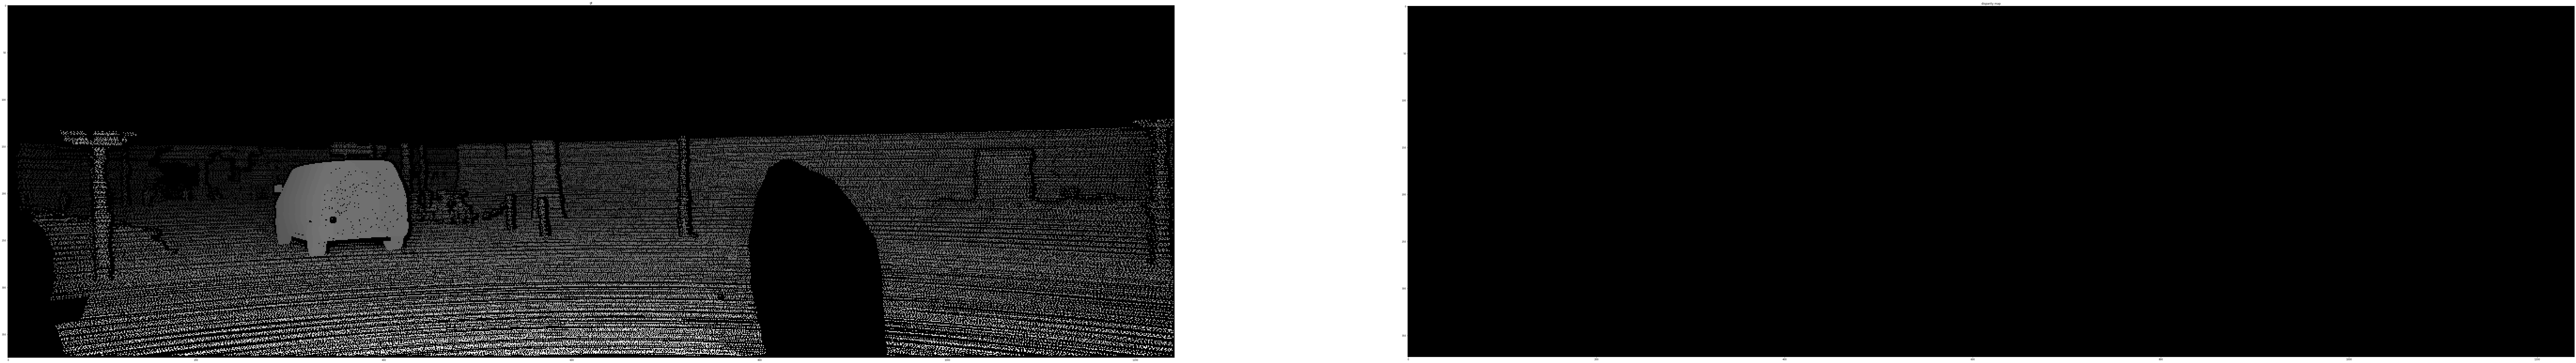


Image KITTI/data_scene_flow/training/image_2\000002_10.png processing finished.

Total execution time = 257.54s
255
(462520, 64)
False
(462520, 1)
0
(373, 1240)
0
Computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.09s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 28.60s)
	Processing paths south-east and north-west...	(done in 29.49s)
	Processing paths south and north...	(done in 28.83s)
	Processing paths south-west and north-east...	(done in 29.98s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 29.35s)
	Processing paths south-east and north-west...

KeyboardInterrupt: 

In [195]:
# stereo = cv2.StereoSGBM_create(
#     minDisparity=0,
#     numDisparities=160,     
#     blockSize=1,
#     P1=8 * 3 * 3 ** 2,
#     P2=32 * 3 * 3 ** 2,
#     disp12MaxDiff=1,
#     uniquenessRatio=15,
#     speckleWindowSize=0,
#     speckleRange=2,
#     preFilterCap=63,
#     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
# )

for image1, image2, gt1, gt2 in zip(glob.glob('KITTI/data_scene_flow/training/image_2/0000[0-1][0-9]_10.png'), 
                                      glob.glob('KITTI/data_scene_flow/training/image_2/0000[0-1][0-9]_11.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_0/0000[0-1][0-9]_10.png'),
                                      glob.glob('KITTI/data_scene_flow/training/disp_noc_1/0000[0-1][0-9]_10.png')):
    
    dawn = t.time()
    
    imgL = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    gtL = cv2.imread(gt1, cv2.IMREAD_GRAYSCALE)
    gtR = cv2.imread(gt2, cv2.IMREAD_GRAYSCALE)
    
    print(np.amax(imgL))
    
    # matrix indices to use as "key points"

    indicesL = np.zeros(((imgL.shape[0]-2)*(imgL.shape[1]-2), 2), dtype=np.int64)
    indicesR = np.zeros(((imgR.shape[0]-2)*(imgR.shape[1]-2), 2), dtype=np.int64)
    
    k = 0
    for i in range(1, imgL.shape[0]-1):
        for j in range(1, imgL.shape[1]-1):
            indicesL[k][0], indicesL[k][1] = i, j
            k += 1
    k = 0
    for i in range(1, imgR.shape[0]-1):
        for j in range(1, imgR.shape[1]-1):      
            indicesR[k][0], indicesR[k][1] = i, j
            k += 1

    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=64, patch_size=3)
    
    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors

    print(descriptorL.shape)
    print(np.amax(descriptorL))
    
    descL = np.ndarray((descriptorL.shape[0],1), dtype=np.int64)
    descR = np.ndarray((descriptorR.shape[0],1), dtype=np.int64)

    for i in range(descriptorL.shape[0]):
        descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        
    for i in range(descriptorR.shape[0]):
        descriptorR[i, 0] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
    
    print(descL.shape)
    print(np.amax(descL))
    
    descriptorL = descL.reshape((373, 1240))
    descriptorR = descL.reshape((373, 1240))
    
    print(descriptorL.shape)
    print(np.amax(descriptorL))

    # SGM matching
    
    print('Computing disparity...')
    
    left_disparity_map, right_disparity_map, left_recall, right_recall = sgm(descriptorL, descriptorR, image1.split('/')[3].split('\\')[1], gt1, gt2)
    #disparity = stereo.compute(descriptorL.astype(np.uint8), descriptorR.astype(np.uint8)).astype(np.float32)/16
    
    left_disparity_norm = np.ndarray((left_disparity_map.shape[0], left_disparity_map.shape[1]))
    right_disparity_norm = np.ndarray((right_disparity_map.shape[0], right_disparity_map.shape[1]))

    left_disparity_norm = cv2.normalize(src=left_disparity_map, dst=left_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    right_disparity_norm = cv2.normalize(src=right_disparity_map, dst=right_disparity_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    
    # Visualization
    
#     fig = plt.figure(figsize=(200, 200))
            
#     x = fig.add_subplot(1,2, 1)
#     x.set_title('imgL')
#     plt.imshow(imgL, cmap='gray')

#     y = fig.add_subplot(1,2, 2)
#     y.set_title('imgR')
#     plt.imshow(imgR, cmap='gray')
    
#     plt.show()
    
    fig = plt.figure(figsize=(200, 200))
    
    x = fig.add_subplot(1,2, 1)
    x.set_title('gt')
    plt.imshow(gtL, cmap='gray')

    y = fig.add_subplot(1,2, 2)
    y.set_title('disparity map')
    plt.imshow(left_disparity_norm, cmap='gray')

    plt.show()
    
    dusk = t.time()
    print('\nImage '+image1+' processing finished.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    print('\n-------------------------------\n')

In [188]:
np.amax(left_disparity_norm)

0

In [176]:
left_disparity_map.shape

(373, 1240)